## <font color='White'>Table of contents<font><a class='anchor' id='top'></a>
- [Pre Processing](#1)
- [Question 1 - PCA](#2)
- [Question 2 - Reconstructed Images](#3)
- [Question 3 - Scatter Plot of Rock Images](#4)
- [Question 4 - Comparing to Human Data](#4)
- [Question 5 - Kmeans Clustering](#6)
- [Question 6 - Expectation Maximization](#7)
- [Question 7 - Feed Forward Neural Network](#8)

#### Imports

In [59]:
# Fashion MNIST dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

# Data Processing
import numpy as np
import pandas as pd

# ML models
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

# Dimension Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding

# Statistics
from scipy.spatial import procrustes
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score

# Visualization
import matplotlib.pyplot as plt

# Image processing
from PIL import Image, ImageOps
import os
import cv2

# misc 
import time
import warnings
warnings.filterwarnings("ignore")


#### Nice Visualizations

In [5]:

plt.rc('font', family='Serif', size=12)  
plt.rc('axes', titlesize=14, titleweight='bold')
plt.rc('axes', labelsize=12, titlesize=14)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

#### Global Variables and file paths


In [6]:
RANDOM_STATE = 99
COLOR_MAP = plt.cm.twilight_shifted
IMAGE_FOLDER = "Data/Rock_Images"
VALIDATION_FOLDER = "Data/Validation_Images"
HUMAN_PREDICTIVE_FEATURES = "Data/mds_360.txt"

<a id="1"></a>
### Pre Processing
Load the rock images

In [7]:

label_maps ={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}


In [8]:
fashion_mnist = datasets.FashionMNIST(root='Data', train=True, download=True, transform=ToTensor(),)

DATA = []
LABELS = []

for image, label in fashion_mnist:
    image_flattened = image.view(-1).numpy()  
    DATA.append(image_flattened)
    LABELS.append(label)
    

100.0%


Extracting Data/FashionMNIST/raw/train-images-idx3-ubyte.gz to Data/FashionMNIST/raw



100.0%


Extracting Data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to Data/FashionMNIST/raw



100.0%


Extracting Data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to Data/FashionMNIST/raw



100.0%


Extracting Data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to Data/FashionMNIST/raw



Taking the first 100 items

In [9]:
DATA = pd.DataFrame(DATA[:1000])
LABELS = LABELS[:1000]

Total Number of Rocks

In [10]:
len(DATA)

1000

Categories of first five images

In [11]:
for n in LABELS[:5]:
    print(label_maps[n])


Ankle Boot
T-shirt
T-shirt
Dress
T-shirt


The total number of features after converting to grayscale, resizing and flatenning image is 65536.

In [12]:
len(DATA.columns)

784

In [13]:
print(DATA.shape)

(1000, 784)


In [14]:
DATA.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.000000,...,0.466667,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,...,0.000000,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129412,0.376471,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


<a id="2"></a>
## Queston 1
Apply PCA to the images from folder '360 Rocks'. How many components do you need to preserve 90% of the variance?


In [15]:
pca = PCA(n_components = 0.9, svd_solver = "full")
X_reduced = pca.fit_transform(DATA)
X_recovered = pca.inverse_transform(X_reduced)

In [16]:
print("Length of reduced vector to preserve 90% variance: ", len(X_reduced[0]))

Length of reduced vector to preserve 90% variance:  69


Number of components required to preserve 90% variance: 69


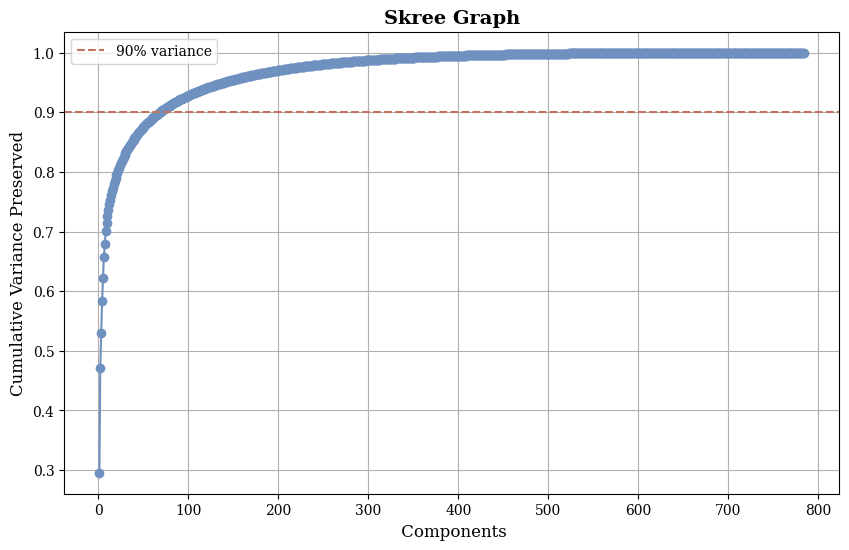

In [17]:
# Getting cumulative variance preserved for every feature included in the PCA.
line_color = COLOR_MAP(.3)
hline_color = COLOR_MAP(.7)

pca = PCA(svd_solver = "full")
pca.fit(DATA)
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components_90 = (cumulative_variance >= 0.90).argmax() + 1

print(f"Number of components required to preserve 90% variance: {n_components_90}")
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color=line_color)
plt.xlabel(' Components')
plt.ylabel('Cumulative Variance Preserved')
plt.title('Skree Graph')
plt.axhline(y=0.90, color='r', linestyle='--', label="90% variance", c=hline_color)
plt.legend()
plt.grid(True)
plt.show()


<a id="3"></a>
## Question 2
Plot 10 images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept 90% of variance using PCA

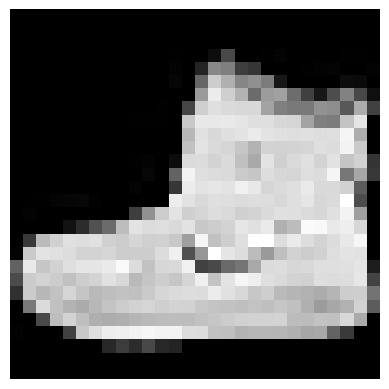

In [88]:
plt.imshow(np.array(DATA.iloc[0, : ]).reshape((28, 28)), cmap = 'grey')
plt.axis('off')
plt.show()

In [89]:
pca = PCA(n_components = 0.9, svd_solver = "full")
X_reduced = pca.fit_transform(DATA)
X_recovered = pca.inverse_transform(X_reduced)

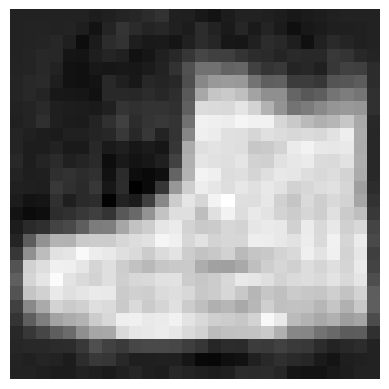

In [90]:
plt.imshow(X_recovered[0].reshape((28, 28)), cmap = "grey")
plt.axis('off')
plt.show()

### Reconstructing 10 Images

<Figure size 1000x1500 with 0 Axes>

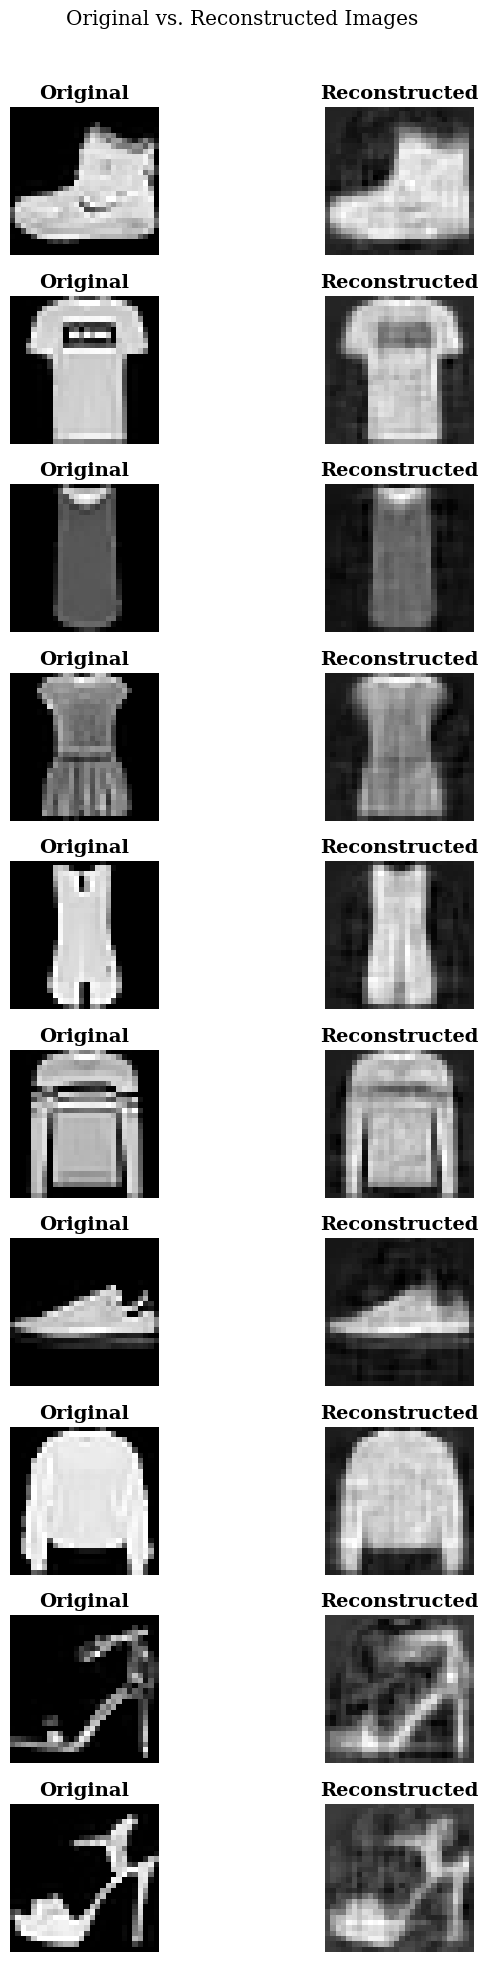

In [91]:
# Plotting the images pre and post reconstruction side by side:

num_images = 10
sample_indices = range(num_images)

plt.figure(figsize = (10, 15))

fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 2))

for i, idx in enumerate(sample_indices):
    axes[i, 0].imshow(np.array(DATA.iloc[idx, : ]).reshape((28, 28)), cmap='gray')
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(X_recovered[idx].reshape((28, 28)), cmap='gray')
    axes[i, 1].set_title("Reconstructed")
    axes[i, 1].axis('off')

plt.suptitle("Original vs. Reconstructed Images")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

<a id="4"></a>
## Question 3
Each of the images belongs to one of ten clothing categories. We will now try to see if clustering visualizations can help us identify different clusters

### 3.A
Use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components?

In [92]:
pca_two = PCA(n_components = 2)
X_reduced_two = pca_two.fit_transform(DATA)
X_recovered_two = pca_two.inverse_transform(X_reduced_two)

In [93]:
pca_two.explained_variance_ratio_

array([0.2955018, 0.1763935], dtype=float32)

In [94]:
print("Total variance explained by the first two components: ", sum(pca_two.explained_variance_ratio_))

Total variance explained by the first two components:  0.47189528


In [95]:
plot_data = pd.DataFrame(columns = ["PC1", "PC2", "Label"])

for itr in range(len(X_reduced_two)):
  curr_row = [X_reduced_two[itr][0], X_reduced_two[itr][1], LABELS[itr]]
  plot_data.loc[len(plot_data)] = curr_row

In [96]:
plot_data

,PC1,PC2,Label
0,-0.630341,6.199270,9.0
1,5.787935,-1.595528,0.0
2,-2.494409,-4.454992,0.0
3,0.463127,-3.854656,3.0
4,3.431532,-4.658764,0.0
...,...,...,...
995,-7.449688,-2.405753,7.0
996,6.657988,-2.510731,3.0
997,-3.740739,-3.670379,3.0
998,-2.002339,5.112372,9.0


### 3.B

Plot a 2D scatter plot of the images spanned by the first two principal components. Each image will be represented with a dot. Make the color of the dot correspond to the image category (so you will have three different colors). Then add some rock images to the visualization to better understand what features in the images are accounting for the majority of variance in the data (your visualization should look similar to the one after line 71 in this file https://github.com/ageron/handson-ml3/blob/main/08_dimensionality_reduction.ipynbLinks to an external site. but with images of rocks instead of MNIST digits). Repeat the process and create the same type of plots for t-SNE, LLE and MDS. [6 points]

In [97]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10), method=None):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    plt.title(method)
    plt.legend()
    
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                    c=[COLOR_MAP(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=COLOR_MAP(float(y[index]) / 9),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = np.array(images.iloc[index, : ]).reshape((28, 28))
                image = cv2.resize(image, (28, 28))
                imagebox = AnnotationBbox(OffsetImage(image, cmap='grey'),
                                          image_coord, frameon=False, arrowprops=dict(arrowstyle="->"))
                ax.add_artist(imagebox)


def plot_principle_components(Reduced_X, method):

    plot_data = pd.DataFrame(
        {
            "PC1": Reduced_X[:, 0],  
            "PC2": Reduced_X[:, 1],  
            "Label": LABELS              
        }
    )

    # Plot data
    plot_digits(
        plot_data[["PC1", "PC2"]],  
        LABELS,                
        images=DATA,               
        figsize=(10, 10),
        method = method            
    )

### PCA

(1000, 2)
1000
Total variance explained by the first two components:  0.4718951


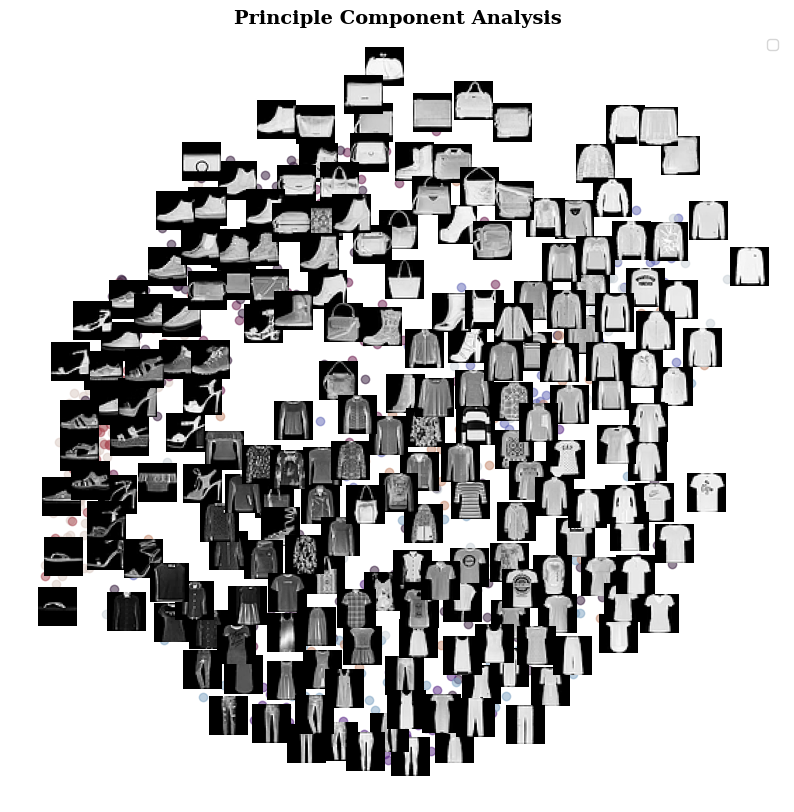

In [98]:
pca_two = PCA(n_components = 2)
Reduced_X = pca_two.fit_transform(DATA)
print(Reduced_X.shape)
print(len(LABELS))

method = 'Principle Component Analysis'
plot_principle_components(Reduced_X, method)
print("Total variance explained by the first two components: ", sum(pca_two.explained_variance_ratio_))


### Local Linear Embedding

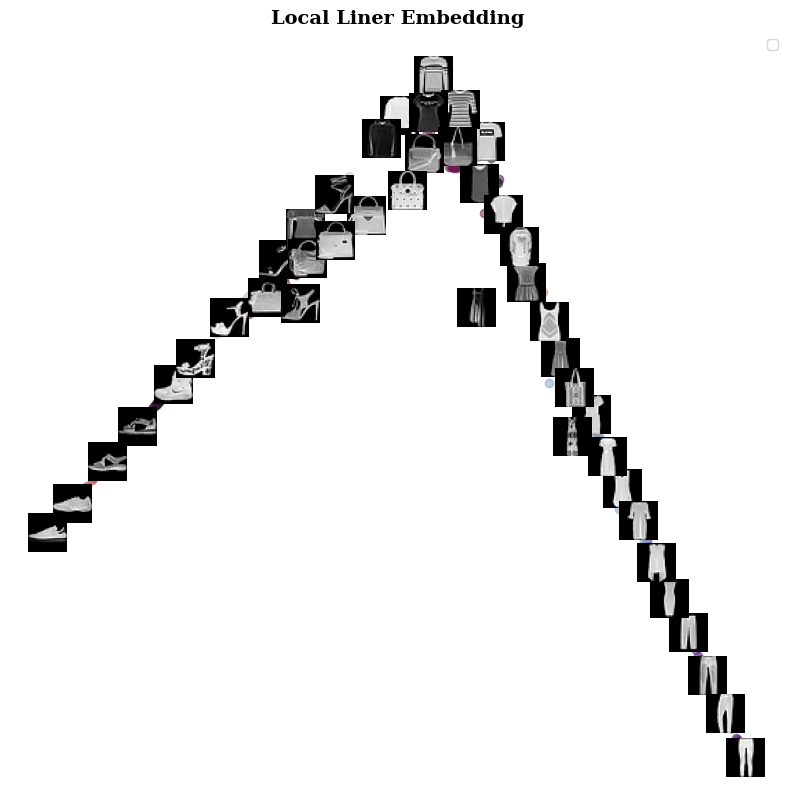

In [99]:

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=5) 
Reduced_X = lle.fit_transform(DATA)
method = 'Local Liner Embedding'
plot_principle_components(Reduced_X, method)

### T-SNE

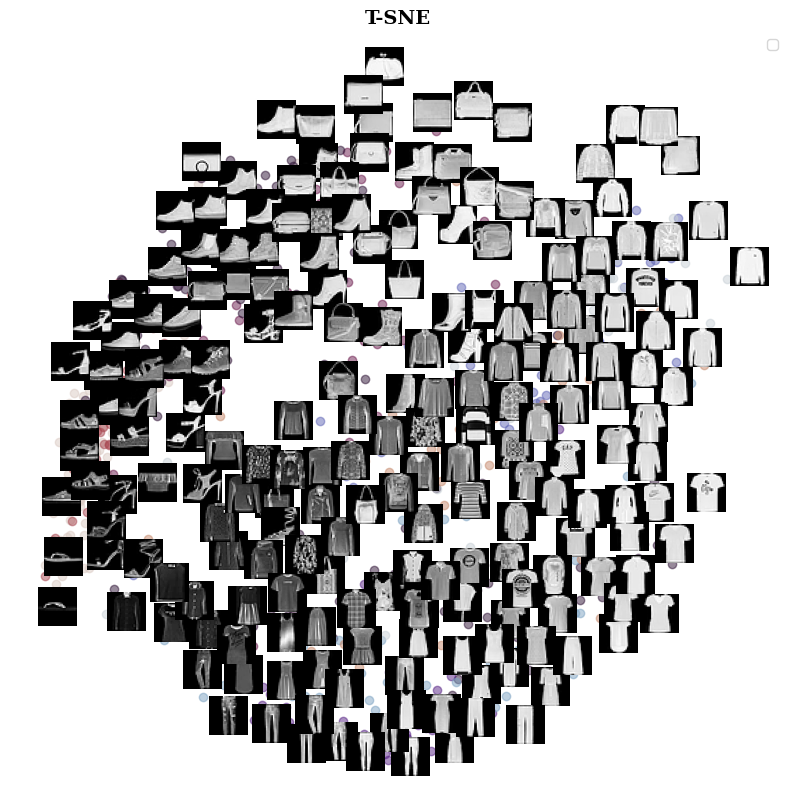

In [100]:

tsne = TSNE(n_components=2, perplexity=1, random_state=0)  
Reduced_X = pca_two.fit_transform(DATA)
method = 'T-SNE'
plot_principle_components(Reduced_X, method)


### MDS

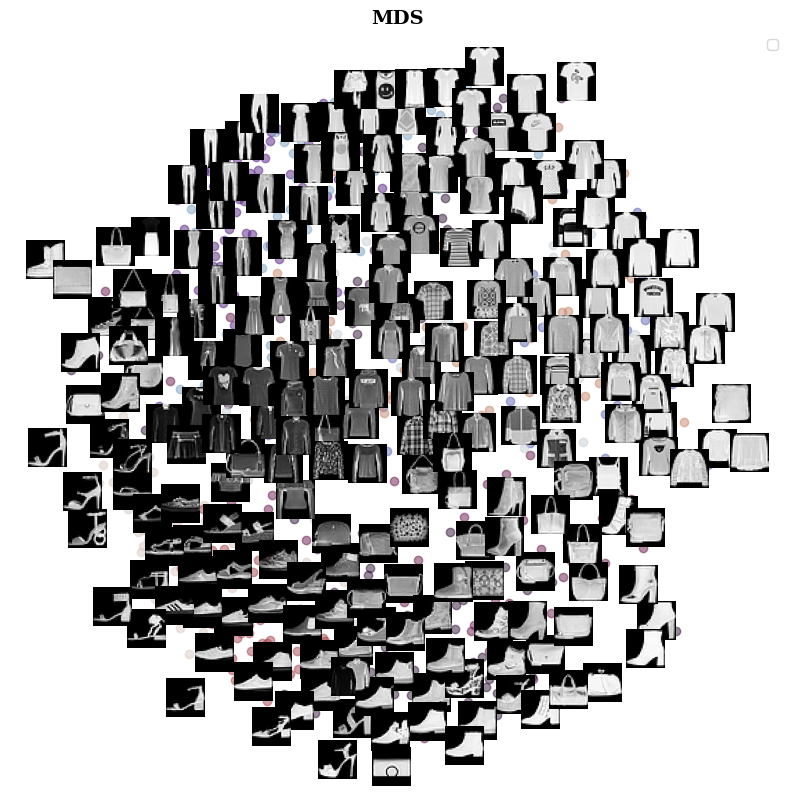

In [101]:

mds = MDS(n_components=2, random_state=0) 
Reduced_X = mds.fit_transform(DATA)
method = 'MDS'
plot_principle_components(Reduced_X, method)


### Observations


From the different decomposition methods, we notice that decomposition is particulary sensisitve to catgeorization of light and dark colored clothing objects rather than the shapes of the images. This seems intuitive as the dataframe only accounts for the pixel grey scale values without the consideration of computer vision techniques to recognize shapes. Another interesting observation is in the shape of the local linear embeddign decomposition which resembles a sort of arrow. 

<a id="6"></a>
## Question 5

Cluster the 360 images using K-Means

In [27]:
def evaluate_clustering_accuracy(predicted_labels):
    contingency_matrix = confusion_matrix(LABELS, predicted_labels)

    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    label_mapping = {pred_label: true_label for pred_label, true_label in zip(col_ind, row_ind)}

    aligned_predicted_labels = np.array([label_mapping[label] for label in predicted_labels])

    accuracy = accuracy_score(LABELS, aligned_predicted_labels)
    # print(f"Clustering Accuracy: {accuracy}")
    return accuracy

### 5.A 
Determining the number of clusters using silhoutte score

In [50]:
pca = PCA(n_components=.90, random_state=RANDOM_STATE)
matrix_with_pca_embeddings_data = pca.fit_transform(DATA)
silhouette_scores = []
accuracy_scores = []
cluster_range = range(2, 25)
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init="auto")
    cluster_labels = kmeans.fit_predict(matrix_with_pca_embeddings_data)

    score = silhouette_score(DATA, cluster_labels)
    silhouette_scores.append(score)

    accuracy = evaluate_clustering_accuracy(cluster_labels)
    accuracy_scores.append(accuracy)

In [53]:
print(silhouette_scores)
print(accuracy_scores)

[np.float32(0.20063996), np.float32(0.16433373), np.float32(0.18594408), np.float32(0.16724722), np.float32(0.16365048), np.float32(0.14904436), np.float32(0.15865254), np.float32(0.13664035), np.float32(0.1406634), np.float32(0.13392165), np.float32(0.13840503), np.float32(0.14206778), np.float32(0.13472888), np.float32(0.12572196), np.float32(0.12266797), np.float32(0.12014836), np.float32(0.11546522), np.float32(0.11412852), np.float32(0.118521854), np.float32(0.11446609), np.float32(0.11447395), np.float32(0.109314926), np.float32(0.110400975)]
[0.212, 0.269, 0.366, 0.421, 0.462, 0.509, 0.543, 0.563, 0.522, 0.542, 0.528, 0.505, 0.53, 0.49, 0.484, 0.48, 0.467, 0.454, 0.45, 0.424, 0.422, 0.405, 0.392]


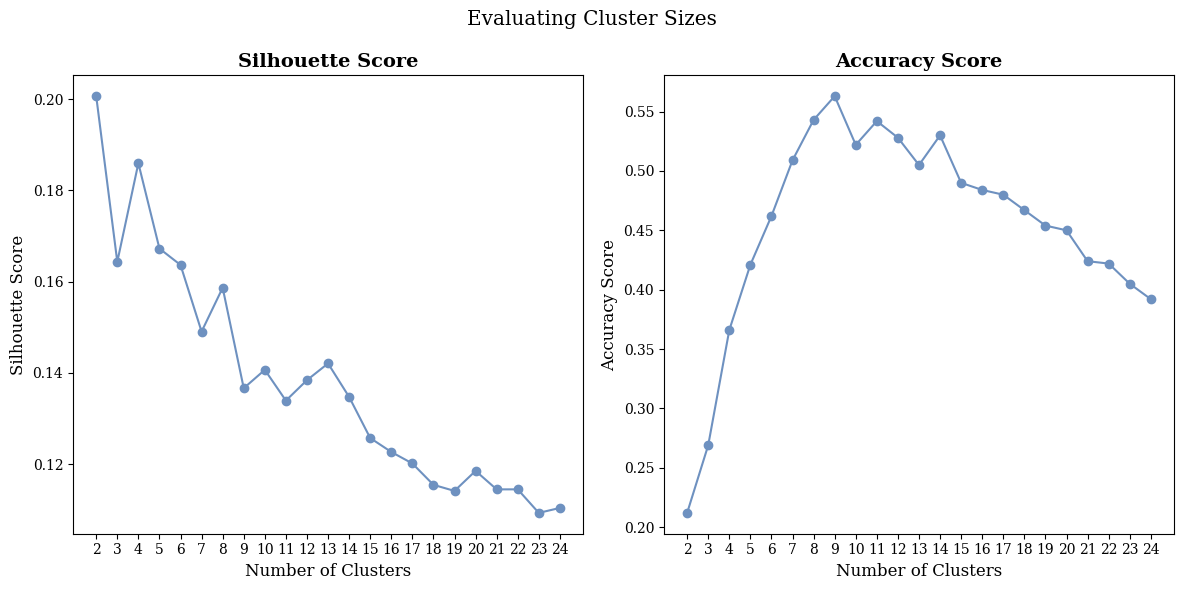

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Silhouette Score
axs[0].plot(cluster_range, silhouette_scores, marker='o', color=line_color)
axs[0].set_title("Silhouette Score")
axs[0].set_xlabel("Number of Clusters")
axs[0].set_xticks(cluster_range)
axs[0].set_ylabel("Silhouette Score")

# Plot for Accuracy Score
axs[1].plot(cluster_range, accuracy_scores, marker='o', color=line_color)
axs[1].set_title("Accuracy Score")
axs[1].set_xlabel("Number of Clusters")
axs[1].set_xticks(cluster_range)
axs[1].set_ylabel("Accuracy Score")

# Adjust layout
plt.suptitle("Evaluating Cluster Sizes")
plt.tight_layout()
plt.show()

Using the Silhouette score to determine optimal clusters, we notice that a smaller amount of clusters provide better clustering results. The highest silhouette score was .2 with 2 clusters 

### 5.B

Evaluting the performance of 10 clusters, one for each true class

In [55]:
pca = PCA(n_components=.90, random_state=RANDOM_STATE)
matrix_with_pca_embeddings_data = pca.fit_transform(DATA)
kmeans = KMeans(n_clusters=10, random_state=RANDOM_STATE, n_init="auto")
kmeans.fit_predict(matrix_with_pca_embeddings_data)

silhouette_avg = silhouette_score(DATA, kmeans.labels_)
print(f"The silhoutte score for 3 clusters: {silhouette_avg}")
accuracy = evaluate_clustering_accuracy(kmeans.labels_)
print(f"Clustering Accuracy: {accuracy}")
stat, p_value = pearsonr(LABELS, kmeans.labels_)
print(f"Correlation Statistic: {stat} \nP_value: {p_value}")



The silhoutte score for 3 clusters: 0.14066340029239655
Clustering Accuracy: 0.522
Correlation Statistic: 0.2999308158574503 
P_value: 3.1081083437393594e-22


Kmeans Cluster labels have a pearson statistic of .29 indicating a weak positive correlation between the cluster labels and the true labels

<a id="7"></a>
## Question 6

Cluster the 360 images using EM

### 6.B 
Determining The Number of Clusters for Gaussian Distributions

In [56]:
bic_scores = []
aic_scores = []
accuracy_scores = []
pca = PCA(n_components=.90, random_state=RANDOM_STATE)
matrix_with_pca_embeddings_data = pca.fit_transform(DATA)
for n_components in cluster_range:
    gm = GaussianMixture(n_components=n_components, random_state=RANDOM_STATE)
    gm.fit(matrix_with_pca_embeddings_data)
    bic_scores.append(gm.bic(matrix_with_pca_embeddings_data))
    aic_scores.append(gm.aic(matrix_with_pca_embeddings_data))

    accuracy = evaluate_clustering_accuracy(gm.fit_predict(matrix_with_pca_embeddings_data))
    accuracy_scores.append(accuracy)

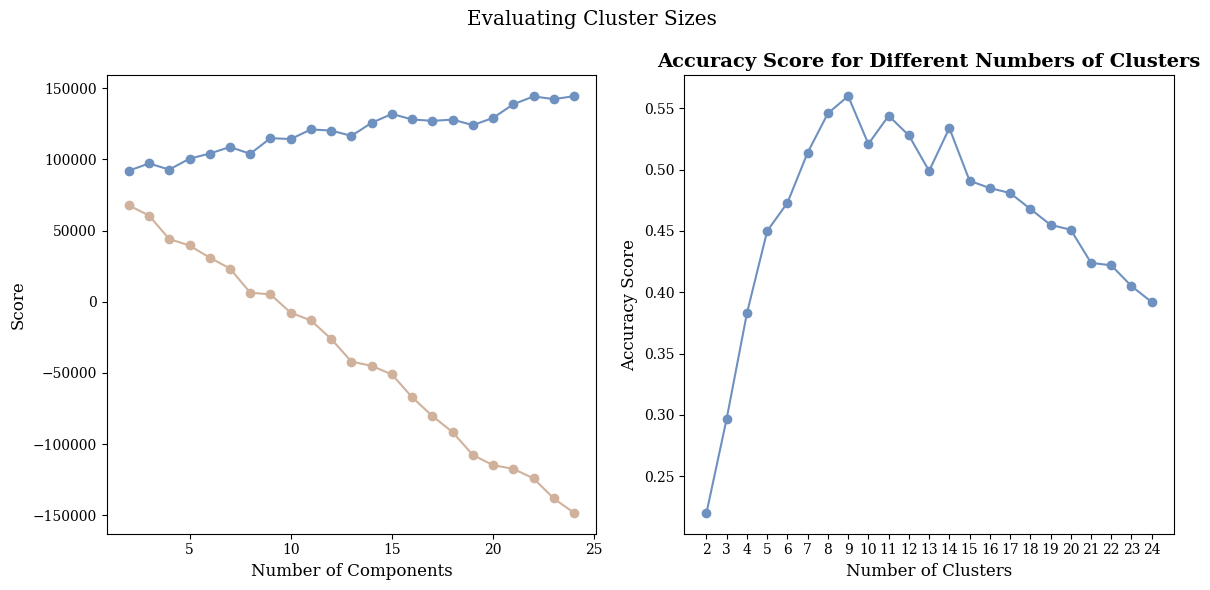

In [57]:

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(cluster_range, bic_scores, label='BIC', marker='o', color=COLOR_MAP(.3))
axs[0].plot(cluster_range, aic_scores, label='AIC', marker='o', color=COLOR_MAP(.6))
axs[0].set_xlabel("Number of Components")
axs[0].set_ylabel("Score")


# Plot for Accuracy Score
axs[1].plot(cluster_range, accuracy_scores, marker='o', color=line_color)
axs[1].set_title("Accuracy Score for Different Numbers of Clusters")
axs[1].set_xlabel("Number of Clusters")
axs[1].set_xticks(cluster_range)
axs[1].set_ylabel("Accuracy Score")

# Adjust layout
plt.suptitle("Evaluating Cluster Sizes")
plt.tight_layout()
plt.show()

we used AIC and BIC to calculate the optimal amount of clusters, however the plot did not provide a good selection for this. This could indicate that it is best to use a small amoutn fo clusters

### 6.B 
Set the number of Clusters to 10 and report clustering accuracy against true labels

In [58]:
pca = PCA(n_components=.90, random_state=RANDOM_STATE)
matrix_with_pca_embeddings_data = pca.fit_transform(DATA)
gm = GaussianMixture(n_components=10, random_state=RANDOM_STATE)

predicted = gm.fit_predict(matrix_with_pca_embeddings_data)

accuracy = evaluate_clustering_accuracy(predicted)
print(f"Clustering Accuracy: {accuracy}")
stat, p_value = pearsonr(LABELS, predicted)
print(f"Correlation Statistic: {stat} \nP_value: {p_value}")

Clustering Accuracy: 0.521
Correlation Statistic: 0.2737534521508349 
P_value: 1.1974556478901295e-18


The Gaussian Mixture Cluster labels have a pearson statistic of .27 indicating a weak positive correlation between the cluster labels and the true labels

### 6.C 
Sampling 20 Images from the Gaussian Distributions



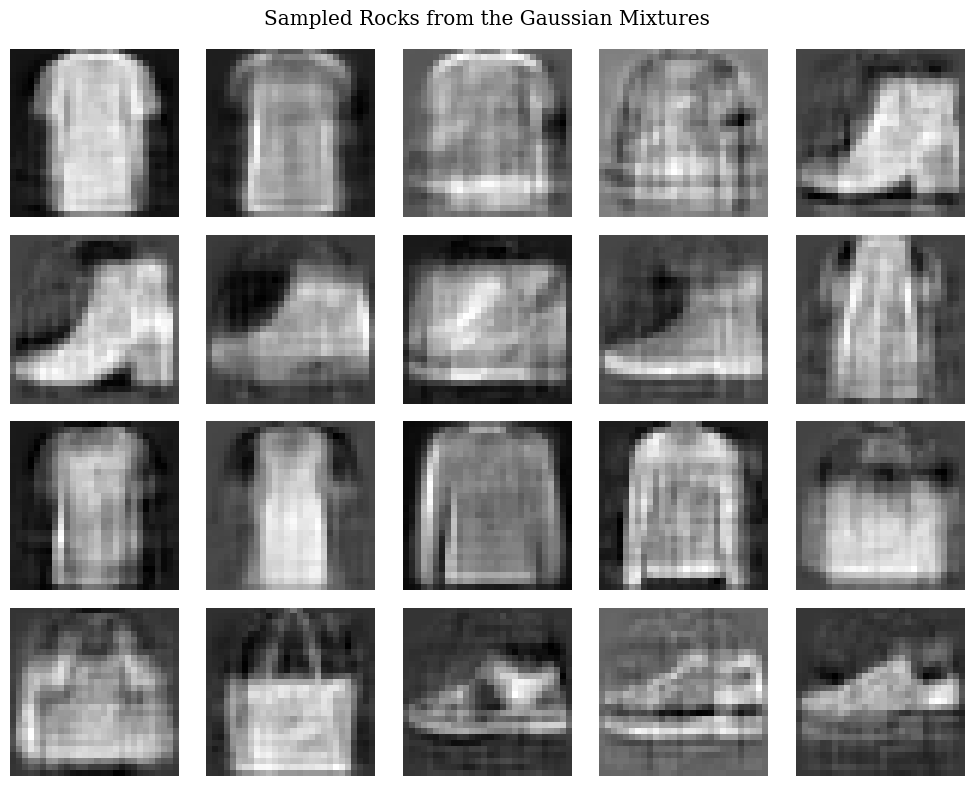

In [111]:
gm = GaussianMixture(n_components=10, random_state=RANDOM_STATE)
gm.fit(matrix_with_pca_embeddings_data)

samples, _ = gm.sample(n_samples=20)
original_space_samples = pca.inverse_transform(samples)

fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(np.array(original_space_samples[i, : ]).reshape((28,28)), cmap = 'grey')
    ax.axis('off')
plt.suptitle("Sampled Rocks from the Gaussian Mixtures")
plt.tight_layout()
plt.show()

Sampling 2 rocks from each cluster

In [112]:
n_samples_per_cluster = 2 
original_space_samples = []

for cluster_idx in range(gm.n_components):

    mean = gm.means_[cluster_idx]
    cov = gm.covariances_[cluster_idx]
    samples_from_cluster = np.random.multivariate_normal(mean, cov, n_samples_per_cluster)
    
    original_space_samples.extend(pca.inverse_transform(samples_from_cluster))

original_space_samples = np.array(original_space_samples)

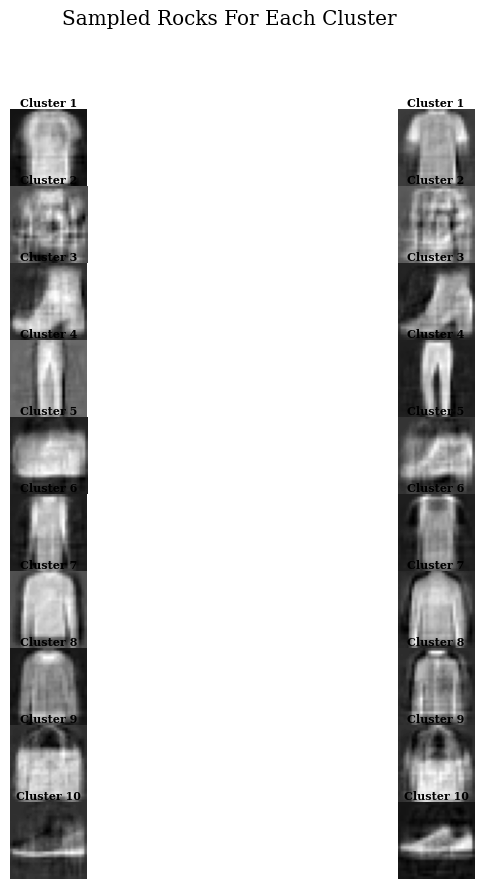

In [113]:
fig, axes = plt.subplots(gm.n_components, n_samples_per_cluster, figsize=(10, 10))
for i, ax in enumerate(axes.ravel()):
    cluster_label = i // n_samples_per_cluster
    ax.imshow(np.array(original_space_samples[i, :]).reshape((28, 28)), cmap='grey')
    ax.axis('off')
    ax.set_title(f"Cluster {cluster_label+1}", fontsize=8, pad=2)

plt.suptitle("Sampled Rocks For Each Cluster")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

<a id="8"></a>
## Question 7 
Build a feedforward neural network (using dense and/or CNN layers) with a few hidden layers (we suggest using Keras (within Tensorflow) or Pytorch). Train the network to classify on 360 rock images using rock name as the label - the category is indicated by the first letter in the filename (I, M and S). Use images from '120 Rocks' folder as your validation data. Choose the number of neurons you find appropriate and efficient (so you have enough time to run it), but make the last layer before the softmax should consist of 8 neurons. The hidden layers should have ReLU activation function. Train the network for multiple epochs until it converges (if the process is too slow, tweak the learning rate and consider simplifying your network). We will not deduct points based on the simplicity of your network, but we expect you to have performance that is above chance performance that could be obtained with an untrained network - in other words, we expect to see train and validation loss decrease and accuracy increase throughout the training

Imports

In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn.functional import normalize
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary



Setting Hyper Parameters

In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 28*28
hidden_size = 256
num_classes = 10
num_epochs = 50
batch_size = 100
learning_rate = 0.001

### Converting Data

Since FashionMNIST comes from pytorch we can easily convert this into a pytorch dataset

In [116]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [117]:
train_dataset = datasets.FashionMNIST(root='Data', 
                                           train=True, 
                                           transform=test_transform,  
                                           download=True)

test_dataset = datasets.FashionMNIST(root='Data', 
                                          train=False, 
                                          transform=test_transform)

# Data loader
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


### Building The Model

In [118]:
    
class RockClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RockClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)  

        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)  
        
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
        
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.softmax = nn.Softmax(1)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn1(x)  
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)  
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x) 
        return self.softmax(x)
    


def train_model(model, Training_DataLoader, device, optimizer, criterion):
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0
    
    for images, labels in Training_DataLoader:
        # print(images.shape)
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
        train_total += labels.size(0)

    train_loss /= len(Training_DataLoader) 
    train_accuracy = train_correct / train_total 
    
    return train_accuracy, train_loss

def eval_model(model, Test_DataLoader, device, criterion):
    model.eval()
    test_correct, test_total, test_loss = 0, 0, 0
    
    with torch.no_grad():
        for images, labels in Test_DataLoader:
     
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
        
            test_loss += criterion(outputs, labels).item()
            test_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
            test_total += labels.size(0)



    test_loss /= len(Test_DataLoader)
    test_accuracy = test_correct/test_total

    return test_accuracy, test_loss


In [119]:

model = RockClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  
model.to(device)



RockClassifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
)

### 7.A
Report Training Time

In [120]:
%time train_model(model, train_dataloader, device, optimizer, criterion)

CPU times: user 4.8 s, sys: 169 ms, total: 4.97 s
Wall time: 4.95 s


(0.7997333333333333, 1.6875239535172781)

Training time took roughly 5s for one epoch

### 7.B 
Plot training and validation lost as a function of training epochs

In [121]:

# Lists to store metrics for each epoch
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

for epoch in range(num_epochs):
    print(f"Current Epoch: {epoch+1}", end='\r')
    
    # Training
    train_accuracy, train_loss = train_model(model, train_dataloader, device, optimizer, criterion)
    training_accuracy.append(train_accuracy)
    training_loss.append(train_loss / len(train_dataloader))

    # Validation
    val_accuracy, val_loss = eval_model(model, test_dataloader, device, criterion)
    validation_accuracy.append(val_accuracy)
    validation_loss.append(val_loss/len(test_dataloader))



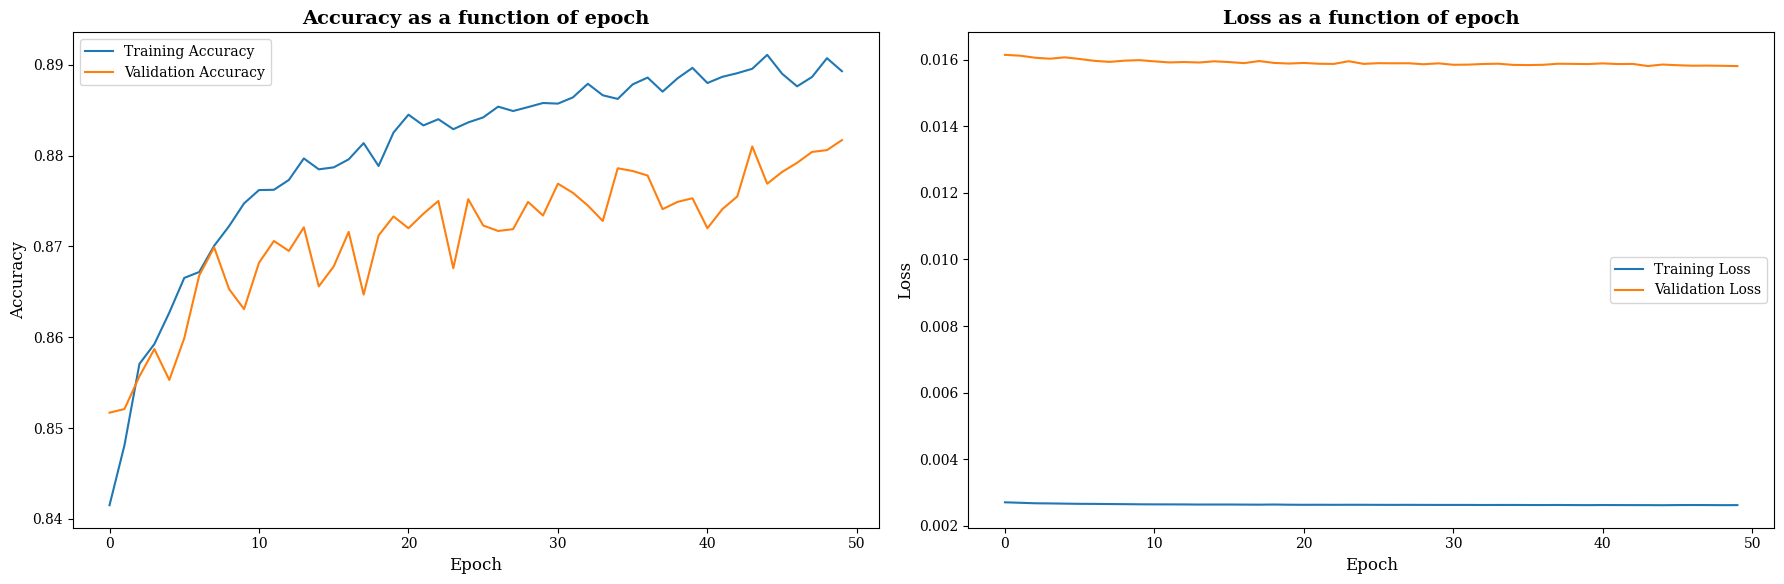

In [122]:
x = list(range(num_epochs))

fig, axs = plt.subplots(1, 2, figsize=(18, 6)) 

# Plot accuracy
axs[0].plot(x, training_accuracy, label='Training Accuracy')
axs[0].plot(x, validation_accuracy, label='Validation Accuracy')
axs[0].set_title('Accuracy as a function of epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot loss
axs[1].plot(x, training_loss, label='Training Loss')
axs[1].plot(x, validation_loss, label='Validation Loss')
axs[1].set_title('Loss as a function of epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

### Observations

Our Neural Network is demonstrating promising performance, with validation accuracy improving alongside training accuracy in the later epochs. This suggests that the model is generalizing well and is not overfitting to the training data. However, it is noteworthy that the loss function remains constant over several epochs. This behavior could indicate that the model has reached a plateau in terms of optimization, potentially due to the learning rate being too low, the choice of loss function not effectively capturing further improvements, or the network converging to a local minimum. Further analysis might be required to ensure that the loss function's stagnation is not impeding the model's ability to achieve its full potential. Possible next steps could include experimenting with different learning rates, fine-tuning the model architecture, or adjusting the regularization techniques being employed.

### 7.C 

How many parameters does the network have? How many of those parameters are bias parameters?

Number of Weights and Biases per Layer

In [123]:

for name, param in model.named_parameters():
    if "weight" in name:
        print(f"Layer: {name} | Weights: {len(param.data)}")
    elif "bias" in name:
        print(f"Layer: {name} | Biases: {len(param.data)}")


Layer: fc1.weight | Weights: 256
Layer: fc1.bias | Biases: 256
Layer: bn1.weight | Weights: 256
Layer: bn1.bias | Biases: 256
Layer: fc2.weight | Weights: 128
Layer: fc2.bias | Biases: 128
Layer: bn2.weight | Weights: 128
Layer: bn2.bias | Biases: 128
Layer: fc3.weight | Weights: 10
Layer: fc3.bias | Biases: 10


Neural Network Architecture

In [124]:

summary(model, input_size=(batch_size, 28*28))

Layer (type:depth-idx)                   Output Shape              Param #
RockClassifier                           [100, 10]                 --
├─Linear: 1-1                            [100, 256]                200,960
├─BatchNorm1d: 1-2                       [100, 256]                512
├─ReLU: 1-3                              [100, 256]                --
├─Dropout: 1-4                           [100, 256]                --
├─Linear: 1-5                            [100, 128]                32,896
├─BatchNorm1d: 1-6                       [100, 128]                256
├─ReLU: 1-7                              [100, 128]                --
├─Dropout: 1-8                           [100, 128]                --
├─Linear: 1-9                            [100, 10]                 1,290
├─Softmax: 1-10                          [100, 10]                 --
Total params: 235,914
Trainable params: 235,914
Non-trainable params: 0
Total mult-adds (M): 23.59
Input size (MB): 0.31
Forward/backward pas